In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
import os
import json
import math
import h5py
import tensorflow as tf
import keras
from numpy import random
from tqdm import tqdm
from matplotlib.pyplot import imshow
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime


## **Data Preprocessing**

In [2]:
directory = "../input/segmentation/Datasets/"

In [3]:
train_dir_images_path = directory + "training/images"
train_dir_masks_path = directory + "training/groundtruth"

In [4]:
train_dir_images = os.listdir(directory + "/training/images")
print("Number of images present in the training dataset", len(train_dir_images))
print("Images present in the training dataset")
print(train_dir_images)

Number of images present in the training dataset 100
Images present in the training dataset
['satImage_005.png', 'satImage_077.png', 'satImage_025.png', 'satImage_037.png', 'satImage_046.png', 'satImage_047.png', 'satImage_052.png', 'satImage_015.png', 'satImage_069.png', 'satImage_010.png', 'satImage_065.png', 'satImage_093.png', 'satImage_040.png', 'satImage_053.png', 'satImage_068.png', 'satImage_041.png', 'satImage_011.png', 'satImage_085.png', 'satImage_056.png', 'satImage_027.png', 'satImage_061.png', 'satImage_023.png', 'satImage_086.png', 'satImage_073.png', 'satImage_033.png', 'satImage_049.png', 'satImage_034.png', 'satImage_084.png', 'satImage_090.png', 'satImage_035.png', 'satImage_006.png', 'satImage_004.png', 'satImage_009.png', 'satImage_074.png', 'satImage_024.png', 'satImage_075.png', 'satImage_089.png', 'satImage_071.png', 'satImage_064.png', 'satImage_057.png', 'satImage_038.png', 'satImage_059.png', 'satImage_088.png', 'satImage_067.png', 'satImage_080.png', 'satIma

In [5]:
train_dir_masks = os.listdir(directory + "/training/groundtruth")
print("Number of masks present in the training dataset", len(train_dir_masks))
print("Masks present in the training dataset")
print(train_dir_masks)

Number of masks present in the training dataset 100
Masks present in the training dataset
['satImage_005.png', 'satImage_077.png', 'satImage_025.png', 'satImage_037.png', 'satImage_046.png', 'satImage_047.png', 'satImage_052.png', 'satImage_015.png', 'satImage_069.png', 'satImage_010.png', 'satImage_065.png', 'satImage_093.png', 'satImage_040.png', 'satImage_053.png', 'satImage_068.png', 'satImage_041.png', 'satImage_011.png', 'satImage_085.png', 'satImage_056.png', 'satImage_027.png', 'satImage_061.png', 'satImage_023.png', 'satImage_086.png', 'satImage_073.png', 'satImage_033.png', 'satImage_049.png', 'satImage_034.png', 'satImage_084.png', 'satImage_090.png', 'satImage_035.png', 'satImage_006.png', 'satImage_004.png', 'satImage_009.png', 'satImage_074.png', 'satImage_024.png', 'satImage_075.png', 'satImage_089.png', 'satImage_071.png', 'satImage_064.png', 'satImage_057.png', 'satImage_038.png', 'satImage_059.png', 'satImage_088.png', 'satImage_067.png', 'satImage_080.png', 'satImage

In [6]:
print(train_dir_images_path + train_dir_images[0])

../input/segmentation/Datasets/training/imagessatImage_005.png


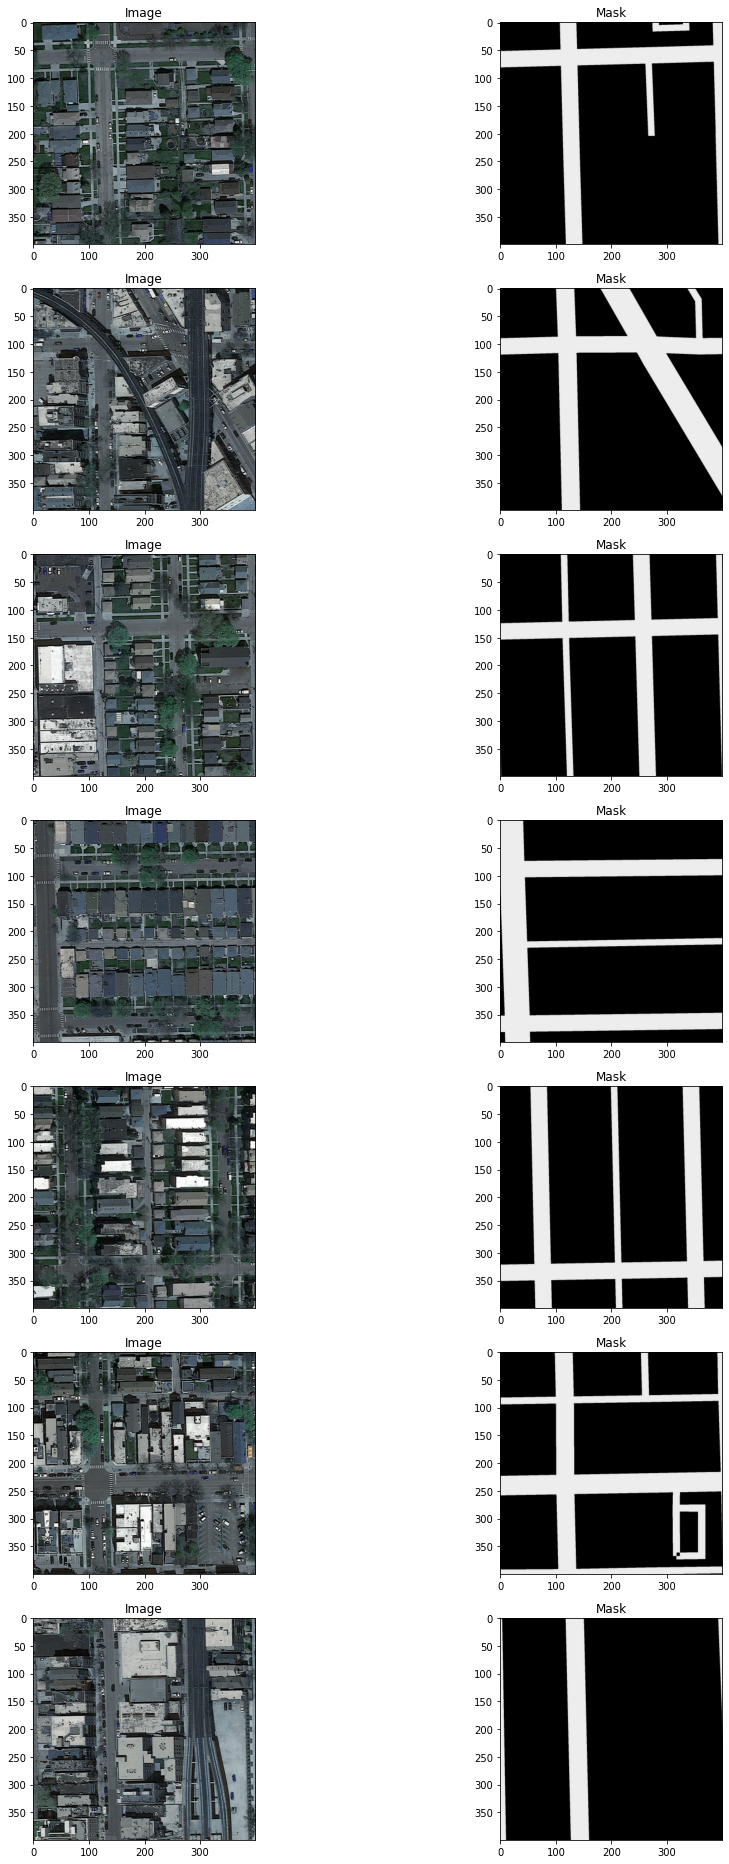

In [7]:
fig, axs = plt.subplots(7,2, figsize=(16,26))
count = 0
for x in range(7):
  ix = random.randint(0, len(train_dir_images)) # select a random index
  axs[count][0].title.set_text("Image") # set title
  axs[count][0].imshow(cv2.imread(train_dir_images_path + '/' + train_dir_images[ix])) # show MRI 
  axs[count][1].title.set_text("Mask") # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(train_dir_masks_path + '/' + train_dir_masks[ix])) # Show corresponding mask
  count += 1

fig.tight_layout()

In [8]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy

(400, 400, 3)


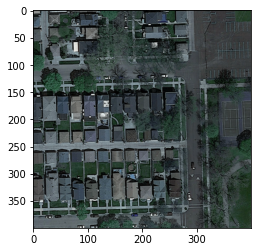

In [9]:
mask =cv2.imread(train_dir_images_path + '/' + train_dir_images[0])
imshow(mask)
print(mask.shape)

(400, 400, 3)


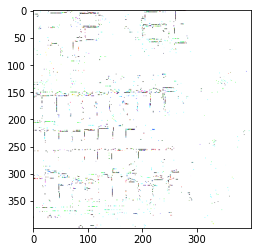

In [10]:
mask = noisy("gauss",mask)
imshow(mask)
print(mask.shape)

In [ ]:
# fig, axs = plt.subplots(7, figsize=(50,50))
# count = 0
# for x in range(7):
#   ix = random.randint(0, len(train_dir_images)) # select a random index
#   mask = cv2.imread(train_dir_masks_path + '/' + train_dir_masks[ix])
#   mask = noisy('gauss', mask)
#   axs.imshow(mask) # Show corresponding mask
    
# fig.tight_layout()

In [11]:
all_images = []
for filename in train_dir_images:
    #print(train_dir_images_path + '/' + filename)
    image = cv2.imread(train_dir_images_path + '/' + filename)
    image = cv2.resize(image,(608,608),cv2.INTER_AREA)
    # print(image.shape)
    #PREPROCESSING of training images

    all_images.append(image)

    flipVertical = cv2.flip(image, 0)
    all_images.append(flipVertical)
    flipHorizontal = cv2.flip(image, 1)
    all_images.append(flipHorizontal)
    flipBoth = cv2.flip(image, -1)
    all_images.append(flipBoth)


    img_rotate_90_clockwise = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # img_rotate_90_clockwise = cv2.resize(img_rotate_90_clockwise,(608,608),cv2.INTER_AREA)
    all_images.append(img_rotate_90_clockwise)


    img_rotate_90_counterclockwise = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #img_rotate_90_counterclockwise = cv2.resize(img_rotate_90_counterclockwise,(608,608),cv2.INTER_AREA)
    all_images.append(img_rotate_90_counterclockwise)


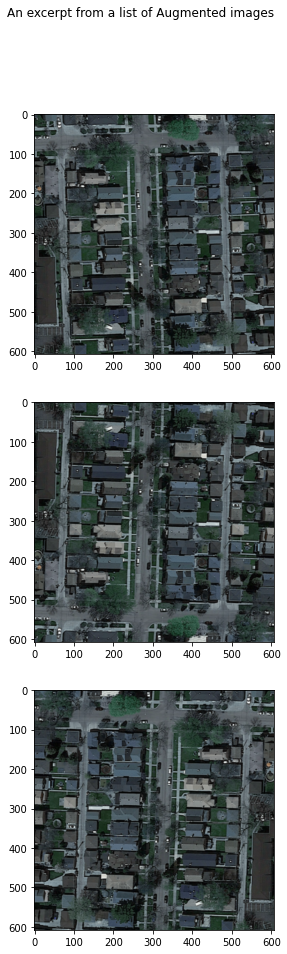

In [12]:
fig, axes = plt.subplots(3, figsize=(15,15))
fig.suptitle('An excerpt from a list of Augmented images')
axes[0].imshow(all_images[300])
axes[1].imshow(all_images[301])
axes[2].imshow(all_images[302])

In [13]:
all_masks = []
for filename in train_dir_masks:
    mask = cv2.imread(train_dir_masks_path + '/' + filename)
    #PREPROCESSING of training masks
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask,(608,608),cv2.INTER_AREA)

    ret,thresh1 = cv2.threshold(mask,64,255,cv2.THRESH_BINARY)
    mask = thresh1
    all_masks.append(mask)


    flipVerticalMask = cv2.flip(mask, 0)
    all_masks.append(flipVerticalMask)
    flipHorizontalMask = cv2.flip(mask, 1)
    all_masks.append(flipHorizontalMask)
    flipBothMask = cv2.flip(mask, -1)
    all_masks.append(flipBothMask)


    img_rotate_90_clockwise_Mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
  # img_rotate_90_clockwise = cv2.resize(img_rotate_90_clockwise,(608,608),cv2.INTER_AREA)
    all_masks.append(img_rotate_90_clockwise_Mask)


    img_rotate_90_counterclockwise_Mask = cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
  # img_rotate_90_counterclockwise = cv2.resize(img_rotate_90_counterclockwise,(608,608),cv2.INTER_AREA)
    all_masks.append(img_rotate_90_counterclockwise_Mask)


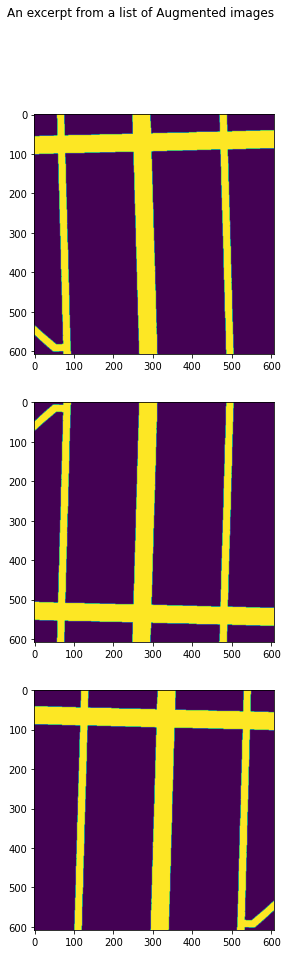

In [14]:
fig, axes = plt.subplots(3, figsize=(15,15))
fig.suptitle('An excerpt from a list of Augmented images')
axes[0].imshow(all_masks[300])
axes[1].imshow(all_masks[301])
axes[2].imshow(all_masks[302])

In [15]:
all_images = np.asarray(all_images)
all_masks = np.asarray(all_masks)
print("Shape of training images")
print(all_images.shape)
print("Shape of masks")
print(all_masks.shape)

Shape of training images
(600, 608, 608, 3)
Shape of masks
(600, 608, 608)


In [16]:
np.unique(all_masks)

array([  0, 255], dtype=uint8)

In [17]:
np.unique(all_images[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [18]:
with h5py.File('train_images.h5py', 'w') as hf:
        hf.create_dataset("all_images",  data=all_images)

with h5py.File('train_masks.h5py', 'w') as hf:
        hf.create_dataset("all_masks",  data=all_masks)

## **MODEL PHASE**

In [19]:
IMAGE_HEIGHT = IMAGE_WIDTH = 608
NUM_CHANNELS = 3
image_file = '../input/fork-of-ml-project-7a88d2/train_images.h5py'
mask_file = '../input/fork-of-ml-project-7a88d2/train_masks.h5py'

In [20]:
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('all_images')
images = np.array(n1)
print(images.shape)
#print("Unique elements in the training images:", np.unique(images))
hfile.close()

(600, 608, 608, 3)


In [21]:
hfile = h5py.File(mask_file, 'r')
n1 = hfile.get('all_masks')
masks = np.array(n1)
print(masks.shape)
#print("Unique elements in the training mask:", np.unique(masks))
hfile.close()

(600, 608, 608)


In [22]:
masks = np.expand_dims(masks, -1)

In [23]:
print(images.shape)
print(masks.shape)

(600, 608, 608, 3)
(600, 608, 608, 1)


In [24]:
seed = 42

In [25]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)

In [26]:
print("Original Dataset")
print(images.shape)
print(masks.shape)

Original Dataset
(600, 608, 608, 3)
(600, 608, 608, 1)


In [27]:
print("Training Set")
print(train_images.shape)
print(train_masks.shape)

Training Set
(480, 608, 608, 3)
(480, 608, 608, 1)


In [28]:
print("Test Dataset")
print(test_images.shape)
print(test_masks.shape)

Test Dataset
(120, 608, 608, 3)
(120, 608, 608, 1)


In [29]:
train_images = train_images.astype('float32')
train_masks = train_masks.astype('float32')

In [30]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [31]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 608, 608, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [32]:
EPOCHS = 75
LEARNING_RATE = 0.001
BATCH_SIZE = 16

In [33]:
checkpoint_path = "initial-model.h5"
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              factor=0.1
                             ),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode="min", verbose=1, save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [34]:
optimizer = keras.optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=optimizer,
      loss=soft_dice_loss,
      metrics=[iou_coef, dice_coef, 'accuracy'])

In [35]:
history = model.fit(train_images,
                    train_masks/255,
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = callbacks
                       )

Epoch 1/75
24/24 [==============================] - 27s 702ms/step - loss: 0.5992 - iou_coef: 0.2513 - dice_coef: 0.4008 - accuracy: 0.5958 - val_loss: 0.6011 - val_iou_coef: 0.2471 - val_dice_coef: 0.3989 - val_accuracy: 0.5066

Epoch 00001: val_loss improved from inf to 0.60108, saving model to initial-model.h5
Epoch 2/75
24/24 [==============================] - 14s 582ms/step - loss: 0.3824 - iou_coef: 0.4409 - dice_coef: 0.6176 - accuracy: 0.8138 - val_loss: 0.6036 - val_iou_coef: 0.2482 - val_dice_coef: 0.3964 - val_accuracy: 0.3684

Epoch 00002: val_loss did not improve from 0.60108
Epoch 3/75
24/24 [==============================] - 14s 581ms/step - loss: 0.3132 - iou_coef: 0.5183 - dice_coef: 0.6868 - accuracy: 0.8612 - val_loss: 0.4224 - val_iou_coef: 0.4195 - val_dice_coef: 0.5776 - val_accuracy: 0.7534

Epoch 00003: val_loss improved from 0.60108 to 0.42244, saving model to initial-model.h5
Epoch 4/75
24/24 [==============================] - 14s 583ms/step - loss: 0.3102 - i

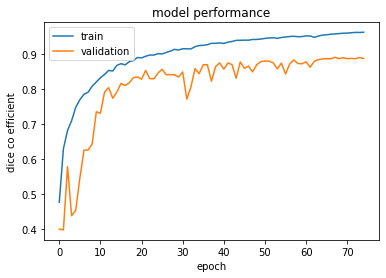

In [36]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model performance')
plt.ylabel('dice co efficient')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

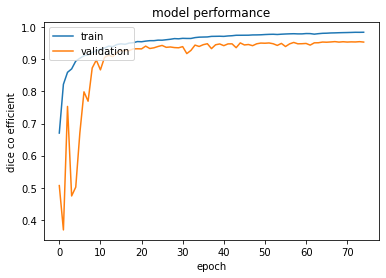

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.ylabel('dice co efficient')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

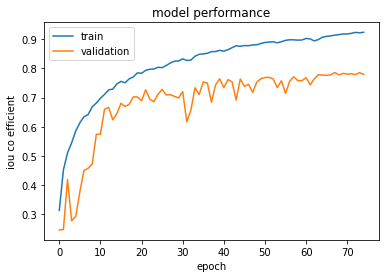

In [38]:
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('model performance')
plt.ylabel('iou co efficient')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model = load_model('../input/unetmodel/unet-road-model.h5', custom_objects={"soft_dice_loss":soft_dice_loss, "iou_coef":iou_coef, "dice_coef":dice_coef})
model.compile(
      optimizer=optimizer,
      loss=soft_dice_loss,
      metrics=[iou_coef, dice_coef])

In [40]:
predictions = model.predict(test_images, verbose=1)

4/4 [==============================] - 4s 688ms/step


In [41]:
print("Predictions made by model: ")
print(predictions.shape)
print("test_masks groundtruth: ")
print(test_masks.shape)

Predictions made by model: 
(120, 608, 608, 1)
test_masks groundtruth: 
(120, 608, 608, 1)


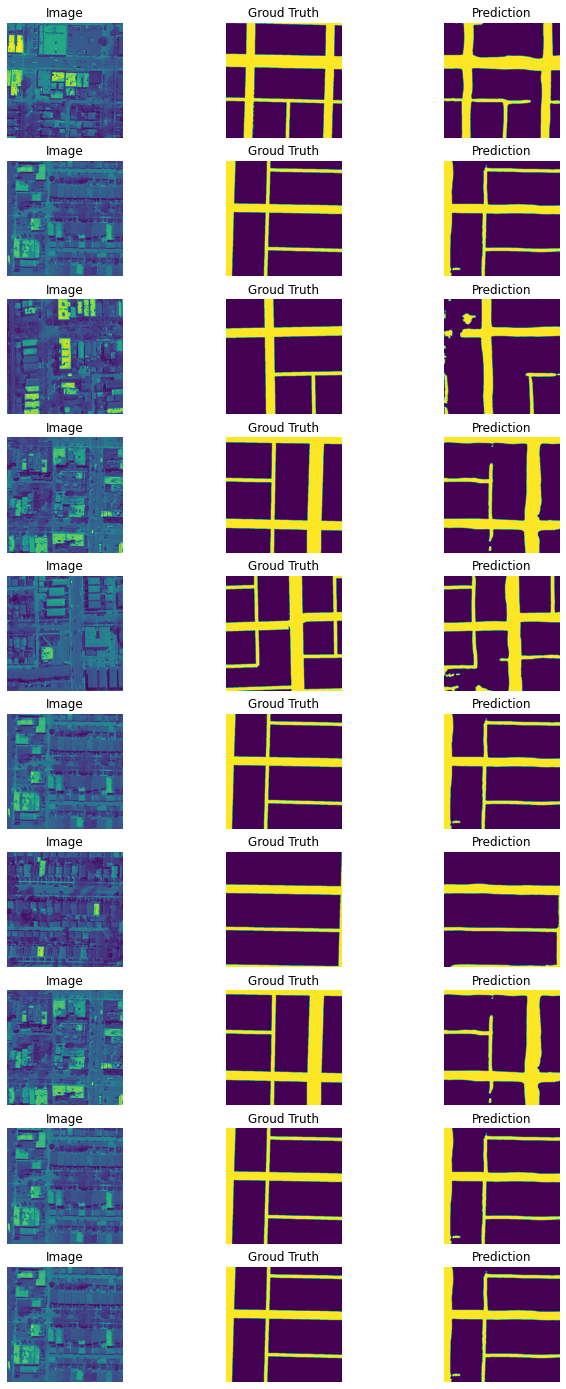

In [44]:
ix = random.randint(0, 10)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, 10)

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

plt.show()
